In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split,KFold
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tf2onnx


In [79]:
# with open("b_values.json") as f:
#     b_values = json.load(f)
    
# with open("avg_amplitude_ratios.json") as f:
#     avg_amplitude_ratios = json.load(f)

with open("results.csv") as f:
    results = f.readlines()
    
strings = ["h_E", "B", "G", "D", "A", "E"]
labels = np.array([0,1,2,3,4,5])
# strings = ["1-2h_E", "1-2B", "1-2G", "1-2D", "1-2A", "1-2E", "2-2h_E", "2-2B", "2-2G", "2-2D", "2-2A", "2-2E"]
# labels = np.array([0,1,2,3,4,5,6,7,8,9,10,11])


data = []
label_list = []

for i, line in enumerate(results):
    if i == 0:
        continue
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        data.append([metric,amp_ra, deviation,f0])
        label_list.append(labels[strings.index(string)])


data = np.array(data, dtype=np.float32)
label_list = np.array(label_list)


scaler = StandardScaler()
data = scaler.fit_transform(data)

label_count = 6
labels_categorical = tf.keras.utils.to_categorical(label_list, num_classes=label_count)


X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42, shuffle=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Convert your data to numpy arrays if they are not already
X = np.array(X_train)
y = np.array(y_train)

# Initialize lists to store the results
val_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 2)
print(f"Training labels shape: {y_train.shape}")

Training data shape: (708, 4)
Training labels shape: (708, 6)


In [80]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(4,)),  
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Dense(32, activation='relu'),
    # Dropout(0.2),

    Dense(label_count, activation='softmax') 
])
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005), metrics=['accuracy'])

# Train the model

print(model.summary())
history = model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=16, validation_split=0.2)
val_accuracies.append(history.history['val_accuracy'][-1])
average_val_accuracy = np.mean(val_accuracies)
print(f'Mean validation accuracy: {average_val_accuracy}')

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_103 (Dense)               │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,054 (39.27 KB)

 Trainable params: 9,670 (37.77 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.1534 - loss: 2.5544 - val_accuracy: 0.2982 - val_loss: 1.7830
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3197 - loss: 1.9211 - val_accuracy: 0.3772 - val_loss: 1.7224
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4211 - loss: 1.6045 - val_accuracy: 0.4035 - val_loss: 1.6893
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4424 - loss: 1.4020 - val_accuracy: 0.4035 - val_loss: 1.6570
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4645 - loss: 1.4182 - val_accuracy: 0.4123 - val_loss: 1.6282
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4330 - loss: 1.3110 - val_accuracy: 0.4474 - val_loss: 1.5929
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5070 - loss: 1.2537 - val_accuracy: 0.5088 - val_loss: 1.5602
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4915 - loss: 1.3027 - val_accuracy: 0.52

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


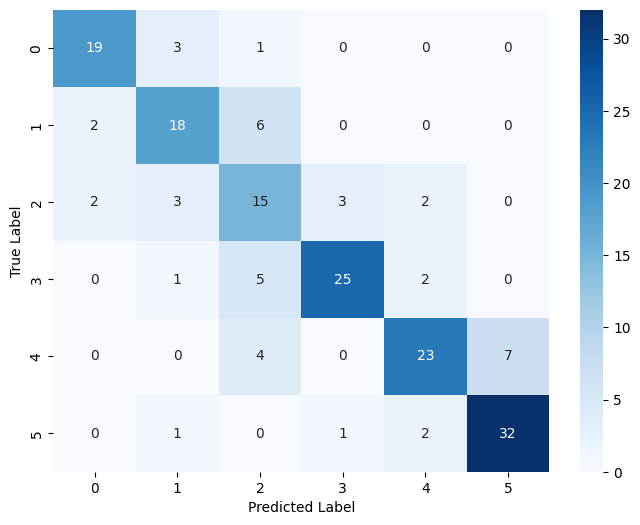

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [82]:
model.save('B_value_model.h5')



model.output_names=['output']
input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name='digit')]

# Convert the Keras model to ONNX format
#onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)


(onnx_model_proto, storage) = tf2onnx.convert.from_keras(model,input_signature=input_signature, opset=13)
with open('modelData.onnx', "wb") as f:
    f.write(onnx_model_proto.SerializeToString())